##imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import time
import copy

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

To import datasets:

Download manually the datasets from https://www.kaggle.com/shayanfazeli/heartbeat. Then uploading to your drive to the directory /content/drive/MyDrive/Deep_Learning/datasets (as written below), or you can choose other directory in drive, but change the link in the code.



In [2]:
from google.colab import drive

drive_path = '/content/drive/MyDrive/Deep_Learning/datasets'
colab_path = '.'

drive.mount('/content/drive', force_remount=True)
!cp -r {drive_path} {colab_path} #line 1

Mounted at /content/drive


##data preparation

In [3]:
def create_pd(train_path,test_path):
    train=pd.read_csv(train_path)
    test=pd.read_csv(test_path)
    train.columns=[x for x in range(188)]
    test.columns=[x for x in range(188)]
    return train,test

### MIT dataset

In [4]:
mit_train_path="./datasets/mitbih_train.csv"
mit_test_path="./datasets/mitbih_test.csv"

In [5]:
mit_train, mit_test= create_pd(mit_train_path,mit_test_path)
mit_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
mit_classes = ['N','S','V','F','Q']

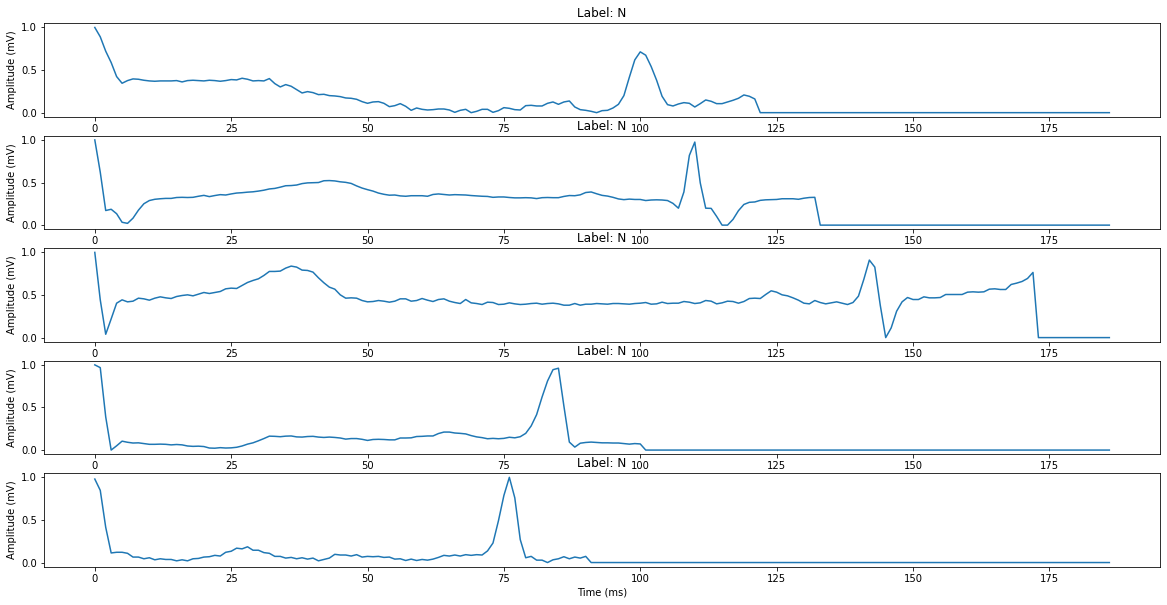

In [7]:
#plot 5 ecg signals in the dataset and their corresponding labels 
fig, ax = plt.subplots(5, 1, figsize=(20, 10))
for i, j in enumerate(np.random.randint(0,len(mit_train),5)):
    ax[i].plot(mit_train.iloc[j, :187])
    ax[i].set_title(f'Label: {mit_classes[int(mit_train.iloc[j,187])]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

In [8]:
print("train relative percentage: {:.3f}%".format(mit_train.shape[0]*100/(mit_train.shape[0]+mit_test.shape[0])))
print("test relative percentage: {:.3f}%".format(mit_test.shape[0]*100/(mit_train.shape[0]+mit_test.shape[0])))

train relative percentage: 79.998%
test relative percentage: 20.002%


In [9]:
mit = pd.concat([mit_train,mit_test], axis=0, join='inner').sort_index()

In [10]:
totals = mit.loc[:,187].value_counts().sort_index().sum()
class_sums = mit.loc[:,187].value_counts().sort_index()
print("classes proportion: ",[round(class_sums[i]/totals,2) for i in range(5)])

classes proportion:  [0.83, 0.03, 0.07, 0.01, 0.07]


###ptb dataset

In [11]:
ptb_normal_path="./datasets/ptbdb_normal.csv"
ptb_abnormal_path="./datasets/ptbdb_abnormal.csv"

In [12]:
ptb_normal, ptb_abnormal= create_pd(ptb_normal_path,ptb_abnormal_path)
ptb = pd.concat([ptb_normal,ptb_abnormal], axis=0, join='inner').sort_index()
ptb.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
class_sums = ptb.loc[:,187].value_counts().sort_index()
print("classes proportion: ",[round(class_sums[i]/len(ptb),2) for i in range(2)])

classes proportion:  [0.28, 0.72]


In [14]:
ptb_train, ptb_test = train_test_split(ptb, test_size=0.2, random_state=0)

In [15]:
ptb_classes = ['normal','abnormal']

##model

In [16]:
class HeartBeatNet(nn.Module):
  def __init__(self,nb_class=5):
    super(HeartBeatNet, self).__init__()
    self.conv_layer = nn.Sequential(
        # Conv Layer block 1
        nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding='valid'),
        nn.BatchNorm1d(32),
        nn.ReLU(inplace=True),

        # Conv Layer block 2
        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding='valid'),
        nn.BatchNorm1d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool1d(kernel_size=3),

        # Conv Layer block 3
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding='valid'),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),

        # Conv Layer block 4
        nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding='valid'),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.AvgPool1d(kernel_size=3)
    )

    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.3),

        nn.Linear(4608, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),

        nn.Linear(1024, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),

        nn.Linear(256, 32),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.3),

        nn.Linear(32, nb_class)
    )
  def forward(self,x):
    """
    x: 1-dim vector of size (Batch ,1, HEARTBEAT_SIZE)
    return: forward pass of x to the convolution and fully connected layers
    """

    x = self.conv_layer(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layer(x)

    return x

##Train function and examples

device

In [17]:
if torch.cuda.is_available():
    print("current cuda device: ", torch.cuda.current_device())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("running calculations on device: ", device)

current cuda device:  0
running calculations on device:  cuda:0


Define the accuracy and loss

In [18]:
def calculate_measurements(model, dataloader, device, criterion, nb_class=5):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_ecg = 0
    running_loss = 0.0
    confusion_matrix = np.zeros([nb_class,nb_class], int)
    with torch.no_grad():
        for data in dataloader:
            ecgs, labels = data
            ecgs = ecgs.to(device)
            labels = labels.to(device)
            outputs = model(ecgs)

            # calculate the loss

            loss = criterion(outputs, labels)
            running_loss += loss.data.item()

            # calculate the total corrects

            _, predicted = torch.max(outputs.data, 1)
            total_ecg += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            ## calculate confusion matrix

            for i, l in enumerate(labels):
              confusion_matrix[l.item(), predicted[i].item()] += 1
    
    running_loss /= len(dataloader)
    model_accuracy = total_correct / total_ecg * 100
    
    return  model_accuracy, confusion_matrix, running_loss

In [19]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

train loop

In [20]:
def train(model,loaders,criterion,optimizer,epochs,scheduler,early_stopping,trial=None):
    
    trainloader , validloader = loaders

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    # training loop
    for epoch in range(1, epochs + 1):
        model.train() # put in training mode
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            ecgs, labels = data
            # send them to device
            ecgs = ecgs.to(device)
            labels = labels.to(device)
            # forward + backward + optimize
            outputs = model(ecgs) # forward pass
            loss = criterion(outputs, labels) # calculate the loss

            optimizer.zero_grad() # zero the parameter gradients
            loss.backward() # backpropagation
            optimizer.step() # update parameters
            # print statistics
            running_loss += loss.data.item()

        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)

        # Calculate training/validation set accuracy of the existing model
        train_accuracy,_,_ = calculate_measurements(model, trainloader, device, criterion)
        valid_accuracy,_,valid_loss = calculate_measurements(model, validloader, device, criterion)
        log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Validation accuracy: {:.3f}%  ".format(epoch, running_loss, 
                                                                                                        train_accuracy,valid_accuracy)
        print(log)

        # save model
        train_losses.append(running_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        # accuracy is used to track down a plateau
        scheduler.step(valid_accuracy) 

        # Early Stopping
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            break

        if trial != None:
            # report back to Optuna how far it is (epoch-wise) into the trial and how 
            # well it is doing (validation accuracy)
            trial.report(valid_accuracy, epoch) 
            
            # then, Optuna can decide if the trial should be pruned
            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    l = len(train_accuracies)
    # Accuracy plot
    figure = plt.figure(figsize=(15,8))
    ax = figure.add_subplot(1,1,1)
    ax.plot(range(1,l+1),train_accuracies,label = "train accuracy")
    ax.plot(range(1,l+1),valid_accuracies,label = "validation accuracy")
    ax.hlines(valid_accuracies[-1],xmin=0,xmax=l+1,colors='orange',linestyles='dashed',alpha=0.5)
    ax.hlines(train_accuracies[-1],xmin=0,xmax=l+1,colors='blue',linestyles='dashed',alpha=0.5)
    ax.legend()
    ax.set_title("Accuracies Curves")
    ax.set_xticks(range(1,l+1,2))
    ax.set_xlim(left=0)
    ax.set_xlabel("Epoch")
    _=ax.set_ylabel("Accuracy (%)")

    # loss plot
    figure = plt.figure(figsize=(15,8))
    ax = figure.add_subplot(1,1,1)
    ax.plot(range(1,l+1),train_losses,label = "train loss")
    ax.plot(range(1,l+1),valid_losses,label = "validation loss")
    ax.hlines(valid_losses[-1],xmin=0,xmax=l+1,colors='orange',linestyles='dashed',alpha=0.5)
    ax.hlines(train_losses[-1],xmin=0,xmax=l+1,colors='blue',linestyles='dashed',alpha=0.5)
    ax.legend()
    ax.set_title("Losses Curves")
    ax.set_xticks(range(1,l+1,2))
    ax.set_xlim(left=0)
    ax.set_xlabel("Epoch")
    _=ax.set_ylabel("Loss")
    
    return valid_accuracies[-1]

Model

In [ ]:
mit_model = HeartBeatNet().to(device)

N.o. weight parameters

In [ ]:
num_trainable_params = sum([p.numel() for p in mit_model.parameters() if p.requires_grad])
print("num trainable weights: ", num_trainable_params)
size_model = 0
for param in mit_model.parameters():
  if param.data.is_floating_point():
    size_model += param.numel() * torch.finfo(param.data.dtype).bits
  else:
    size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")

num trainable weights:  5125125
model size: 164004000 / bit | 20.50 / MB


get the dataloaders

In [21]:
def get_Dataloaders(train,test,batch_size):

    ttrain, tvalid = train_test_split(train, test_size=0.2, random_state=0)

    X_train = torch.tensor(ttrain.loc[:,:186].values,dtype = torch.float32).unsqueeze(1)
    y_train = torch.tensor(ttrain.loc[:,187:].values,dtype=torch.int64).squeeze()

    X_valid = torch.tensor(tvalid.loc[:,:186].values,dtype = torch.float32).unsqueeze(1)
    y_valid = torch.tensor(tvalid.loc[:,187:].values,dtype=torch.int64).squeeze()

    X_test = torch.tensor(test.loc[:,:186].values,dtype = torch.float32).unsqueeze(1)
    y_test = torch.tensor(test.loc[:,187:].values,dtype=torch.int64).squeeze()

    trainloader = torch.utils.data.DataLoader(TensorDataset(X_train,y_train),
    batch_size=batch_size, shuffle=True, num_workers=2)

    validloader = torch.utils.data.DataLoader(TensorDataset(X_valid,y_valid),
    batch_size=batch_size, shuffle=True, num_workers=2)

    testloader = torch.utils.data.DataLoader(TensorDataset(X_test,y_test),
    batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, validloader, testloader

hyperparameters

In [ ]:
nb_class = 5

batch_size = 64
learning_rate = 1e-4
epochs = 200

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mit_model.parameters(), lr=learning_rate)


# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                              verbose=True)

# Early Stopping
early_stopping = EarlyStopping(delta=0.0001, patience=10, verbose=True)

train

Epoch: 1 | Loss: 0.2494 | Training accuracy: 97.312% | Validation accuracy: 97.230%  
Epoch: 2 | Loss: 0.1146 | Training accuracy: 97.911% | Validation accuracy: 97.784%  
Epoch: 3 | Loss: 0.0941 | Training accuracy: 98.244% | Validation accuracy: 98.070%  
Epoch: 4 | Loss: 0.0814 | Training accuracy: 98.531% | Validation accuracy: 98.270%  
Epoch: 5 | Loss: 0.0721 | Training accuracy: 98.468% | Validation accuracy: 98.178%  
EarlyStopping counter: 1 out of 10
Epoch: 6 | Loss: 0.0658 | Training accuracy: 98.729% | Validation accuracy: 98.338%  
Epoch: 7 | Loss: 0.0578 | Training accuracy: 98.932% | Validation accuracy: 98.470%  
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
Epoch: 8 | Loss: 0.0471 | Training accuracy: 99.119% | Validation accuracy: 98.647%  
Epoch: 9 | Loss: 0.0428 | Training accuracy: 99.208% | Validation accuracy: 98.687%  
Epoch: 10 | Loss: 0.0402 | Training accuracy: 99.238% | Validation accuracy: 98.687%  
EarlyStopping counter: 1 out of 10
Epoch: 

98.84643938096053

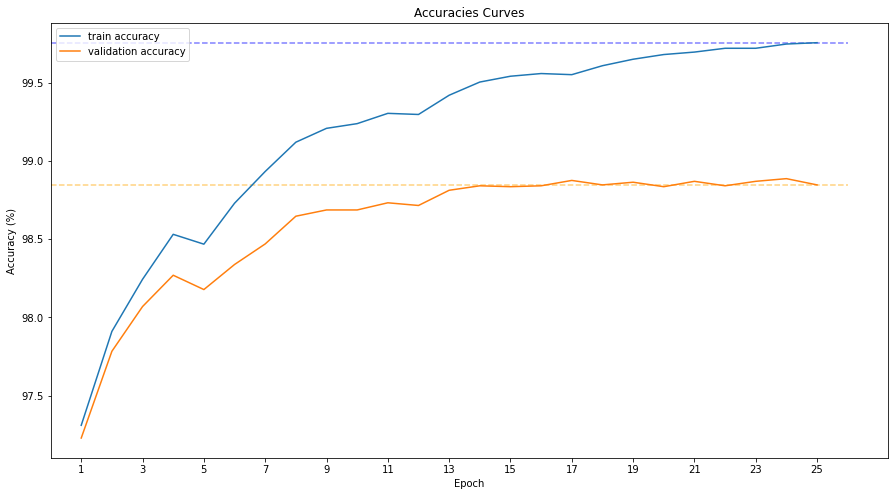

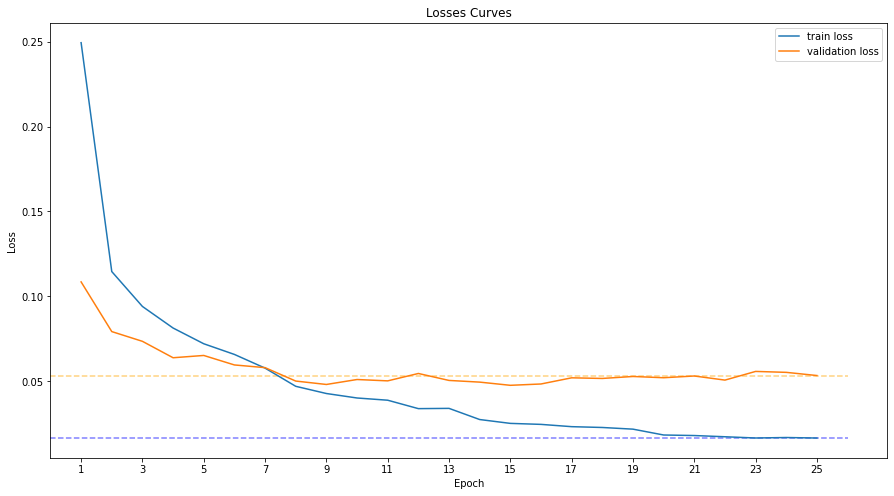

In [ ]:
trainloader,validloader,testloader = get_Dataloaders(mit_train,mit_test,batch_size)

train(mit_model,(trainloader,validloader),criterion,optimizer,epochs,scheduler,early_stopping)

calculating the test accuracy and confusion matrix

test accuracy is: 98.739208%


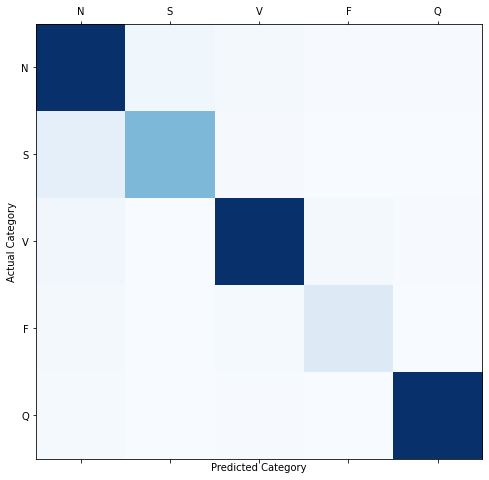

In [ ]:
test_accuracy,confusion_matrix,_ = calculate_measurements(mit_model, testloader, device, criterion, nb_class=5)
print("test accuracy is: {:5f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(nb_class), mit_classes)
plt.xlabel('Predicted Category')
plt.xticks(range(nb_class), mit_classes)
plt.show()

### now training the ptb

In [ ]:
nb_class = 2
ptb_model = HeartBeatNet(nb_class).to(device)

In [ ]:
batch_size = 64
learning_rate = 1e-4
epochs = 200

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(ptb_model.parameters(), lr=learning_rate)


# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                              verbose=True)

# Early Stopping
early_stopping = EarlyStopping(delta=0.0001, patience=10, verbose=True)

Epoch: 1 | Loss: 0.3430 | Training accuracy: 91.978% | Validation accuracy: 91.366%  
Epoch: 2 | Loss: 0.1782 | Training accuracy: 94.749% | Validation accuracy: 94.072%  
Epoch: 3 | Loss: 0.1241 | Training accuracy: 96.714% | Validation accuracy: 96.349%  
Epoch: 4 | Loss: 0.0835 | Training accuracy: 98.475% | Validation accuracy: 98.282%  
Epoch: 5 | Loss: 0.0697 | Training accuracy: 98.604% | Validation accuracy: 97.938%  
Epoch: 6 | Loss: 0.0617 | Training accuracy: 98.142% | Validation accuracy: 97.466%  
EarlyStopping counter: 1 out of 10
Epoch: 7 | Loss: 0.0563 | Training accuracy: 98.776% | Validation accuracy: 97.895%  
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
EarlyStopping counter: 2 out of 10
Epoch: 8 | Loss: 0.0338 | Training accuracy: 99.635% | Validation accuracy: 99.184%  
Epoch: 9 | Loss: 0.0296 | Training accuracy: 99.742% | Validation accuracy: 99.012%  
Epoch: 10 | Loss: 0.0246 | Training accuracy: 99.689% | Validation accuracy: 99.012%  
EarlySt

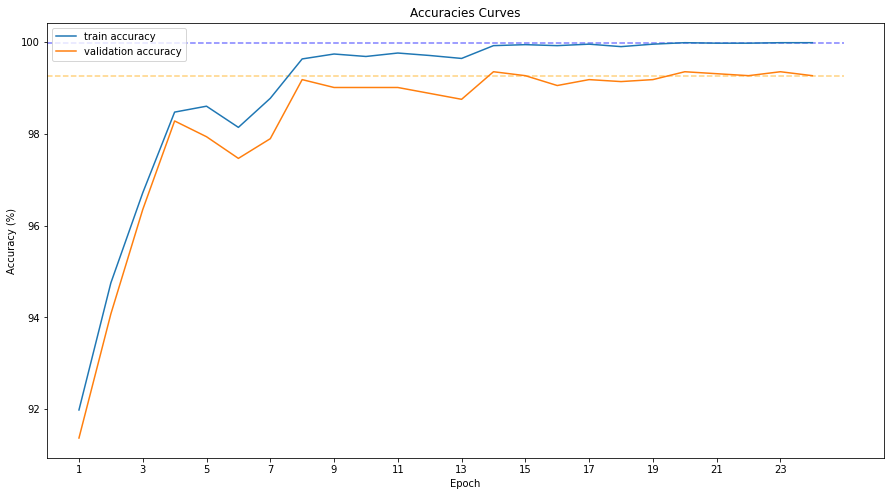

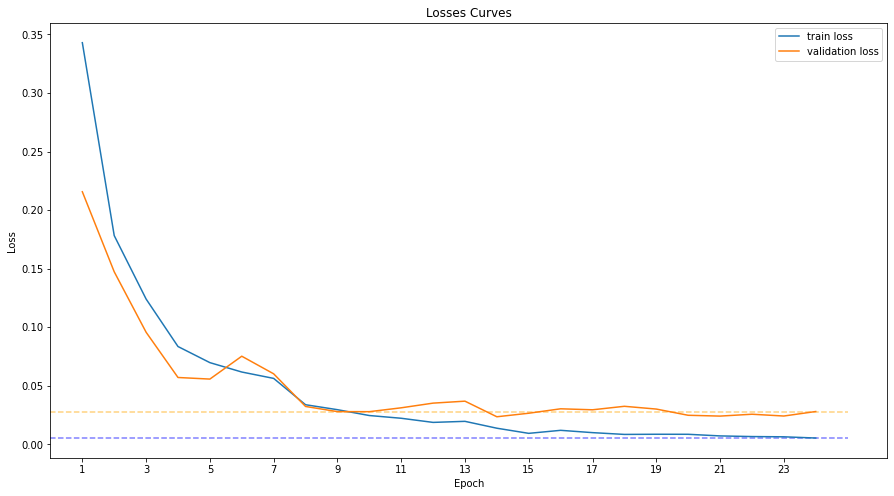

In [ ]:
trainloader,validloader,testloader = get_Dataloaders(ptb_train,ptb_test,batch_size)

since = time.time()
train(ptb_model,(trainloader,validloader),criterion,optimizer,epochs,scheduler,early_stopping)
ptb_time_elapsed = time.time() - since

test accuracy is: 99.347079%


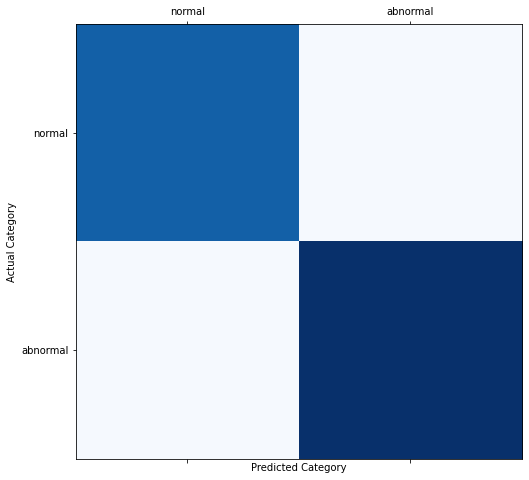

In [ ]:
ptb_test_accuracy,confusion_matrix,_ = calculate_measurements(ptb_model, testloader, device, criterion, nb_class)
print("test accuracy is: {:5f}%".format(ptb_test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(nb_class), ptb_classes)
plt.xlabel('Predicted Category')
plt.xticks(range(nb_class), ptb_classes)
plt.show()

##Tuning with optuna

In [22]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.8 MB/s eta 0:00:00


In [23]:
def compile_model(trial):
    # hyper-parameters
    epochs = 200
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True) # log=True, will use log scale
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True) # log=True, will use log scale
    batch_size = trial.suggest_int("batch_size", 64, 256) # batch_size will be between 64 and 256

    # Generate the model
    model = HeartBeatNet().to(device)

    # load data
    trainloader,validloader,testloader = get_Dataloaders(mit_train,mit_test,batch_size)

    # loss criterion
    criterion = nn.CrossEntropyLoss()

    # optimizer - SGD, Adam, RMSProp...
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate, 
                                               weight_decay=weight_decay)
    
    # Learning Rate Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                                  verbose=True)

    # Early Stopping
    early_stopping = EarlyStopping(delta=0.0001, patience=10, verbose=True)

    # Train the trial
    value = train(model,(trainloader,validloader),criterion,optimizer,epochs,scheduler,early_stopping,trial)
    return value

[I 2023-01-26 11:58:43,094] A new study created in memory with name: ECG-CNN


Epoch: 1 | Loss: 40.6827 | Training accuracy: 82.766% | Validation accuracy: 82.822%  
Epoch: 2 | Loss: 0.4864 | Training accuracy: 82.772% | Validation accuracy: 82.839%  
Epoch: 3 | Loss: 0.4226 | Training accuracy: 92.286% | Validation accuracy: 92.388%  
Epoch: 4 | Loss: 0.3036 | Training accuracy: 84.742% | Validation accuracy: 84.792%  
EarlyStopping counter: 1 out of 10
Epoch: 5 | Loss: 0.2258 | Training accuracy: 95.524% | Validation accuracy: 95.597%  
Epoch: 6 | Loss: 0.2190 | Training accuracy: 96.281% | Validation accuracy: 96.482%  
Epoch: 7 | Loss: 0.1946 | Training accuracy: 95.309% | Validation accuracy: 95.283%  
Epoch 00007: reducing learning rate of group 0 to 4.5904e-03.
EarlyStopping counter: 1 out of 10
Epoch: 8 | Loss: 0.1430 | Training accuracy: 97.382% | Validation accuracy: 97.247%  
Epoch: 9 | Loss: 0.1344 | Training accuracy: 97.372% | Validation accuracy: 97.213%  
Epoch: 10 | Loss: 0.1274 | Training accuracy: 97.681% | Validation accuracy: 97.544%  
Epoch:

[I 2023-01-26 12:06:43,589] Trial 0 finished with value: 98.7265147621495 and parameters: {'learning_rate': 0.00918081314715491, 'weight_decay': 0.00010417572359210358, 'batch_size': 117, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 98.7265147621495.


Epoch: 47 | Loss: 0.0408 | Training accuracy: 99.270% | Validation accuracy: 98.727%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 1.2104 | Training accuracy: 82.759% | Validation accuracy: 82.828%  
Epoch: 2 | Loss: 0.6956 | Training accuracy: 82.759% | Validation accuracy: 82.828%  
Epoch: 3 | Loss: 0.6255 | Training accuracy: 82.759% | Validation accuracy: 82.828%  
Epoch: 4 | Loss: 0.5862 | Training accuracy: 82.759% | Validation accuracy: 82.828%  
Epoch: 5 | Loss: 0.5579 | Training accuracy: 82.957% | Validation accuracy: 83.028%  
Epoch: 6 | Loss: 0.5328 | Training accuracy: 85.477% | Validation accuracy: 85.489%  
Epoch: 7 | Loss: 0.5050 | Training accuracy: 87.295% | Validation accuracy: 87.436%  
Epoch 00007: reducing learning rate of group 0 to 3.7665e-04.
Epoch: 8 | Loss: 0.4878 | Training accuracy: 87.957% | Validation accuracy: 88.139%  
Epoch: 9 | Loss: 0.4741 | Training accuracy: 88.173% | Validation accuracy: 88.316%  
Epoch: 10 | Loss: 0.4643 | Training accur

[I 2023-01-26 12:14:00,944] Trial 1 finished with value: 89.16109873793616 and parameters: {'learning_rate': 0.000753306713830177, 'weight_decay': 0.00010837282906504315, 'batch_size': 144, 'optimizer': 'SGD'}. Best is trial 0 with value: 98.7265147621495.


Epoch: 54 | Loss: 0.3790 | Training accuracy: 89.037% | Validation accuracy: 89.161%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 0.2745 | Training accuracy: 96.840% | Validation accuracy: 96.922%  
Epoch: 2 | Loss: 0.1175 | Training accuracy: 97.469% | Validation accuracy: 97.310%  
Epoch: 3 | Loss: 0.0963 | Training accuracy: 97.883% | Validation accuracy: 97.647%  
Epoch: 4 | Loss: 0.0840 | Training accuracy: 98.174% | Validation accuracy: 97.938%  
Epoch: 5 | Loss: 0.0774 | Training accuracy: 98.517% | Validation accuracy: 98.218%  
Epoch: 6 | Loss: 0.0712 | Training accuracy: 98.461% | Validation accuracy: 98.133%  
EarlyStopping counter: 1 out of 10
Epoch: 7 | Loss: 0.0653 | Training accuracy: 98.612% | Validation accuracy: 98.293%  
Epoch 00007: reducing learning rate of group 0 to 1.3089e-04.
Epoch: 8 | Loss: 0.0518 | Training accuracy: 99.015% | Validation accuracy: 98.572%  
Epoch: 9 | Loss: 0.0481 | Training accuracy: 99.058% | Validation accuracy: 98.567%  
Epoch:

[I 2023-01-26 12:17:17,254] Trial 2 finished with value: 98.87499286162983 and parameters: {'learning_rate': 0.0002617870894989526, 'weight_decay': 0.0005499500856670175, 'batch_size': 230, 'optimizer': 'Adam'}. Best is trial 2 with value: 98.87499286162983.


Epoch: 28 | Loss: 0.0180 | Training accuracy: 99.766% | Validation accuracy: 98.875%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 0.3333 | Training accuracy: 96.745% | Validation accuracy: 96.722%  
Epoch: 2 | Loss: 0.1437 | Training accuracy: 96.435% | Validation accuracy: 96.494%  
EarlyStopping counter: 1 out of 10
Epoch: 3 | Loss: 0.1162 | Training accuracy: 97.710% | Validation accuracy: 97.716%  
Epoch: 4 | Loss: 0.1001 | Training accuracy: 97.866% | Validation accuracy: 97.687%  
Epoch: 5 | Loss: 0.0862 | Training accuracy: 97.050% | Validation accuracy: 97.053%  
EarlyStopping counter: 1 out of 10
Epoch: 6 | Loss: 0.0775 | Training accuracy: 95.267% | Validation accuracy: 95.112%  
EarlyStopping counter: 2 out of 10
Epoch: 7 | Loss: 0.0702 | Training accuracy: 98.464% | Validation accuracy: 98.230%  
Epoch: 8 | Loss: 0.0643 | Training accuracy: 98.522% | Validation accuracy: 98.201%  
Epoch: 9 | Loss: 0.0604 | Training accuracy: 98.801% | Validation accuracy: 98.395% 

[I 2023-01-26 12:20:05,181] Trial 3 finished with value: 98.93781051910227 and parameters: {'learning_rate': 0.0008919785754664355, 'weight_decay': 4.782351268985734e-05, 'batch_size': 190, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 98.93781051910227.


Epoch: 23 | Loss: 0.0187 | Training accuracy: 99.673% | Validation accuracy: 98.938%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 0.6674 | Training accuracy: 83.494% | Validation accuracy: 83.542%  
Epoch: 2 | Loss: 0.4172 | Training accuracy: 89.151% | Validation accuracy: 89.258%  
Epoch: 3 | Loss: 0.3157 | Training accuracy: 92.522% | Validation accuracy: 92.565%  
Epoch: 4 | Loss: 0.2598 | Training accuracy: 94.619% | Validation accuracy: 94.512%  
Epoch: 5 | Loss: 0.2157 | Training accuracy: 94.706% | Validation accuracy: 94.660%  
EarlyStopping counter: 1 out of 10
Epoch: 6 | Loss: 0.1835 | Training accuracy: 96.631% | Validation accuracy: 96.682%  
Epoch: 7 | Loss: 0.1617 | Training accuracy: 96.432% | Validation accuracy: 96.522%  
Epoch 00007: reducing learning rate of group 0 to 1.7157e-03.
Epoch: 8 | Loss: 0.1495 | Training accuracy: 96.919% | Validation accuracy: 96.962%  
Epoch: 9 | Loss: 0.1427 | Training accuracy: 97.030% | Validation accuracy: 97.070%  
Epoch:

[I 2023-01-26 12:35:07,479] Trial 4 finished with value: 97.57295414311005 and parameters: {'learning_rate': 0.003431305036799072, 'weight_decay': 9.855149516573491e-05, 'batch_size': 70, 'optimizer': 'SGD'}. Best is trial 3 with value: 98.93781051910227.


Epoch: 70 | Loss: 0.0985 | Training accuracy: 97.656% | Validation accuracy: 97.573%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 0.2271 | Training accuracy: 97.304% | Validation accuracy: 97.242%  
Epoch: 2 | Loss: 0.1210 | Training accuracy: 97.454% | Validation accuracy: 97.167%  
Epoch: 3 | Loss: 0.0984 | Training accuracy: 97.894% | Validation accuracy: 97.710%  
Epoch: 4 | Loss: 0.0848 | Training accuracy: 98.234% | Validation accuracy: 98.018%  
Epoch: 5 | Loss: 0.0771 | Training accuracy: 98.261% | Validation accuracy: 98.115%  
Epoch: 6 | Loss: 0.0701 | Training accuracy: 98.716% | Validation accuracy: 98.430%  
Epoch: 7 | Loss: 0.0664 | Training accuracy: 98.637% | Validation accuracy: 98.247%  
EarlyStopping counter: 1 out of 10
Epoch: 8 | Loss: 0.0612 | Training accuracy: 98.594% | Validation accuracy: 98.321%  
Epoch 00008: reducing learning rate of group 0 to 2.1531e-04.
EarlyStopping counter: 2 out of 10
Epoch: 9 | Loss: 0.0472 | Training accuracy: 98.864% | Va

[I 2023-01-26 12:38:20,762] Trial 5 finished with value: 98.90354634229914 and parameters: {'learning_rate': 0.0004306237130293496, 'weight_decay': 0.00017459604097671666, 'batch_size': 129, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 98.93781051910227.


Epoch: 21 | Loss: 0.0198 | Training accuracy: 99.689% | Validation accuracy: 98.904%  
EarlyStopping counter: 10 out of 10
Epoch: 1 | Loss: 0.2456 | Training accuracy: 96.646% | Validation accuracy: 96.556%  
Epoch: 2 | Loss: 0.1303 | Training accuracy: 97.419% | Validation accuracy: 97.333%  
Epoch: 3 | Loss: 0.1062 | Training accuracy: 97.701% | Validation accuracy: 97.487%  
Epoch: 4 | Loss: 0.0912 | Training accuracy: 98.154% | Validation accuracy: 97.938%  
Epoch: 5 | Loss: 0.0835 | Training accuracy: 98.352% | Validation accuracy: 98.184%  
Epoch: 6 | Loss: 0.0774 | Training accuracy: 98.261% | Validation accuracy: 98.007%  
EarlyStopping counter: 1 out of 10
Epoch: 7 | Loss: 0.0718 | Training accuracy: 98.214% | Validation accuracy: 97.904%  
Epoch 00007: reducing learning rate of group 0 to 3.0174e-04.
EarlyStopping counter: 2 out of 10
Epoch: 8 | Loss: 0.0555 | Training accuracy: 98.896% | Validation accuracy: 98.544%  
Epoch: 9 | Loss: 0.0521 | Training accuracy: 98.885% | Va

[I 2023-01-26 12:43:32,762] Trial 6 finished with value: 98.91496773456684 and parameters: {'learning_rate': 0.0006034743176822766, 'weight_decay': 0.0002454579540837301, 'batch_size': 117, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 98.93781051910227.


Epoch: 31 | Loss: 0.0151 | Training accuracy: 99.806% | Validation accuracy: 98.915%  
Epoch 00031: reducing learning rate of group 0 to 1.8859e-05.
EarlyStopping counter: 10 out of 10


[I 2023-01-26 12:43:40,498] Trial 7 pruned. 


Epoch: 1 | Loss: 1.5472 | Training accuracy: 82.759% | Validation accuracy: 82.828%  
Epoch: 1 | Loss: 0.2296 | Training accuracy: 97.207% | Validation accuracy: 97.076%  
Epoch: 2 | Loss: 0.1144 | Training accuracy: 97.773% | Validation accuracy: 97.550%  
Epoch: 3 | Loss: 0.0942 | Training accuracy: 98.055% | Validation accuracy: 97.773%  
Epoch: 4 | Loss: 0.0795 | Training accuracy: 98.147% | Validation accuracy: 97.933%  
Epoch: 5 | Loss: 0.0729 | Training accuracy: 98.254% | Validation accuracy: 97.898%  
Epoch: 6 | Loss: 0.0672 | Training accuracy: 98.705% | Validation accuracy: 98.355%  
Epoch: 7 | Loss: 0.0603 | Training accuracy: 98.668% | Validation accuracy: 98.361%  
Epoch 00007: reducing learning rate of group 0 to 2.4051e-04.
Epoch: 8 | Loss: 0.0451 | Training accuracy: 99.016% | Validation accuracy: 98.498%  
Epoch: 9 | Loss: 0.0428 | Training accuracy: 99.186% | Validation accuracy: 98.664%  
Epoch: 10 | Loss: 0.0389 | Training accuracy: 99.220% | Validation accuracy: 9

[I 2023-01-26 12:46:43,314] Trial 8 finished with value: 98.86357146936211 and parameters: {'learning_rate': 0.0004810245348686725, 'weight_decay': 9.542897140130597e-05, 'batch_size': 132, 'optimizer': 'Adam'}. Best is trial 3 with value: 98.93781051910227.


Epoch: 19 | Loss: 0.0196 | Training accuracy: 99.674% | Validation accuracy: 98.864%  
Epoch 00019: reducing learning rate of group 0 to 6.0128e-05.
EarlyStopping counter: 10 out of 10


[I 2023-01-26 12:46:52,834] Trial 9 pruned. 


Epoch: 1 | Loss: 1.5373 | Training accuracy: 82.716% | Validation accuracy: 82.765%  
Study statistics: 
 Number of finished trials:  10
 Number of pruned trials:  2
 Number of complete trials:  8
Best trial:
 Value:  98.93781051910227
 Params: 
 learning_rate: 0.0008919785754664355
 weight_decay: 4.782351268985734e-05
 batch_size: 190
 optimizer: RMSprop


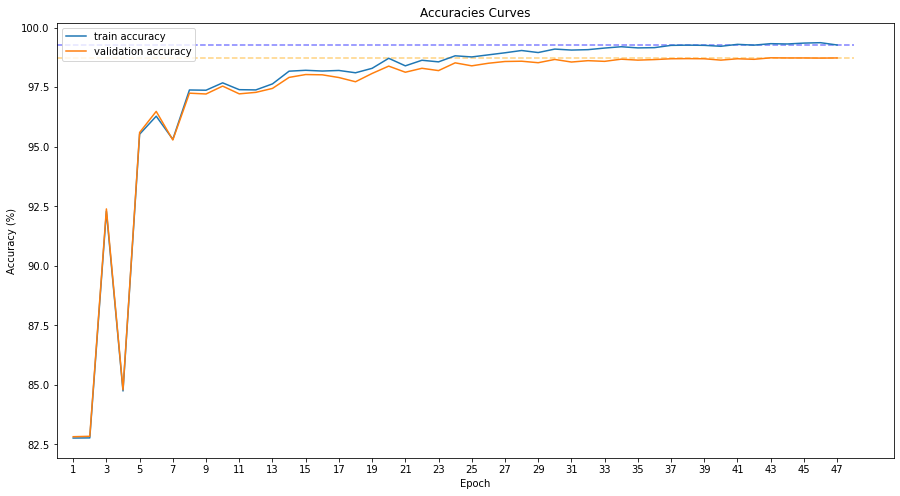

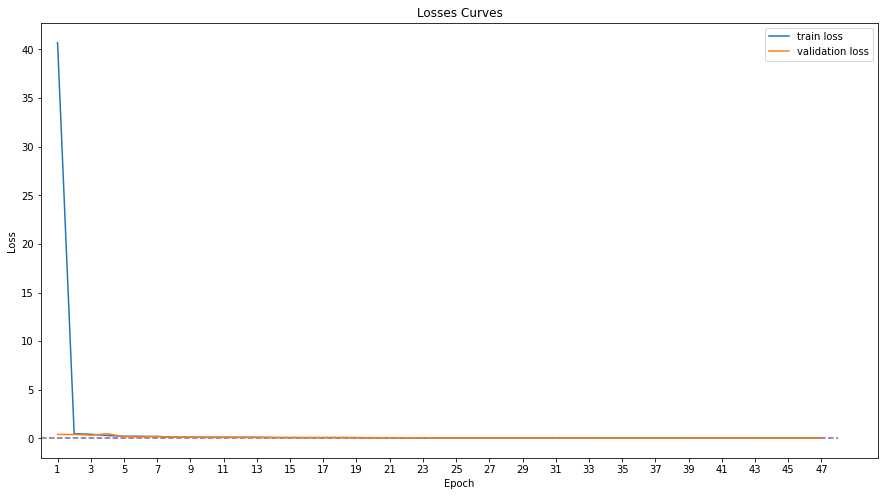

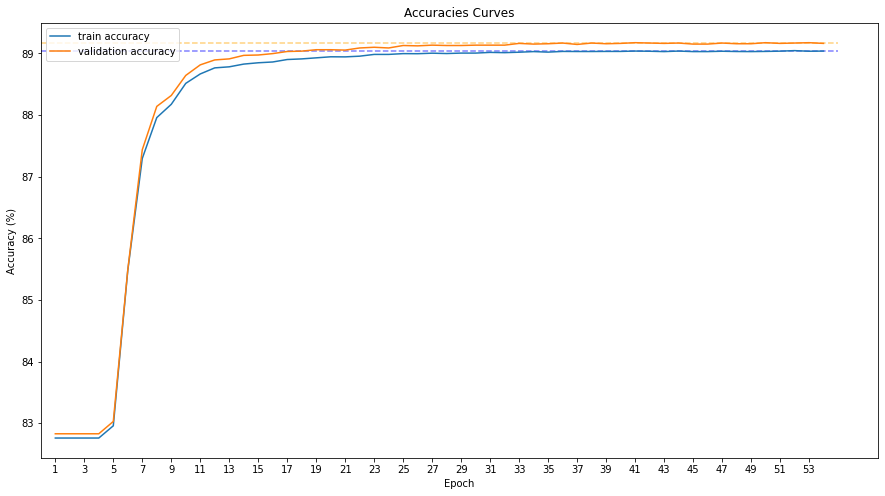

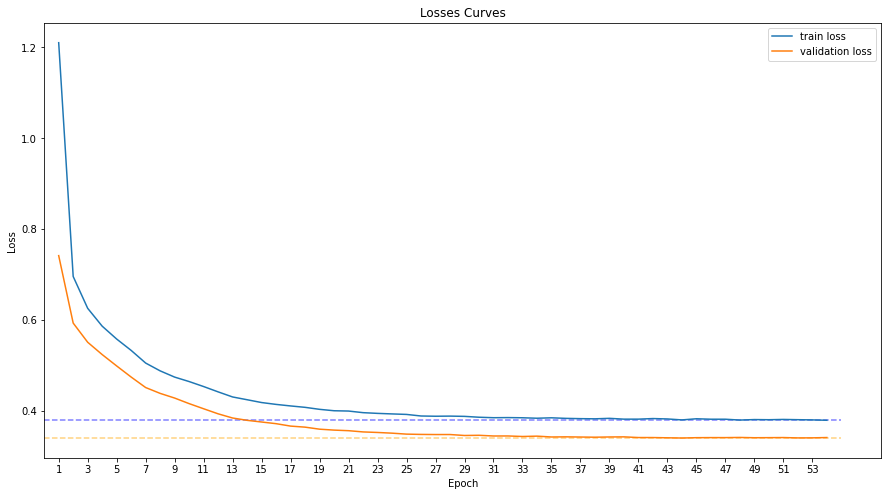

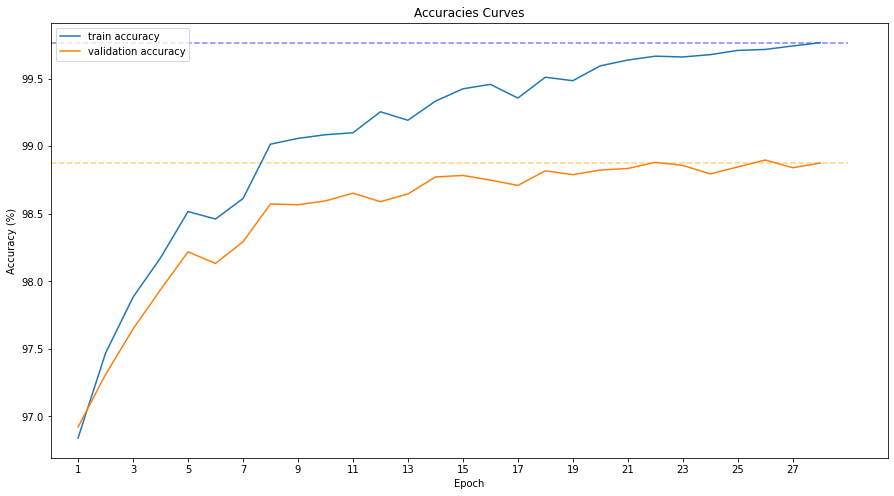

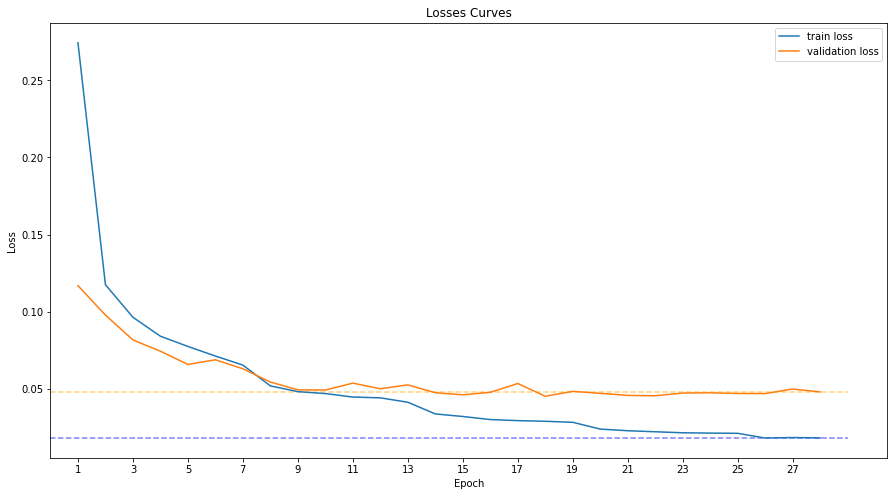

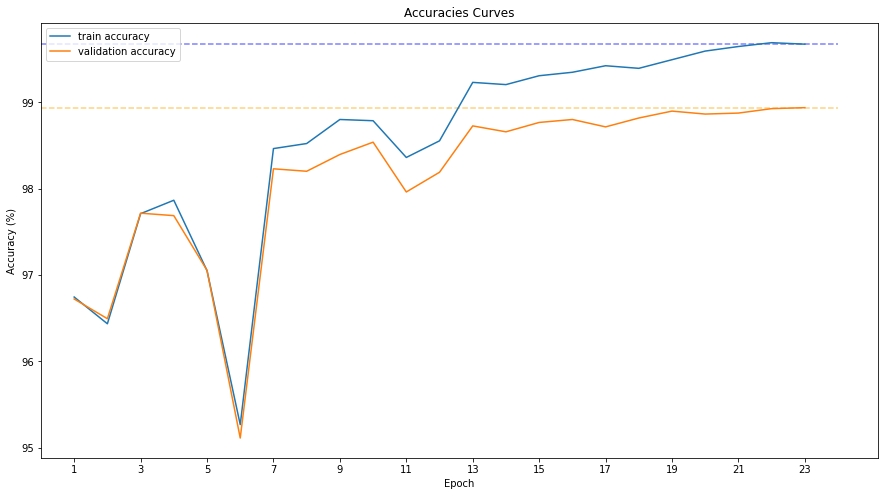

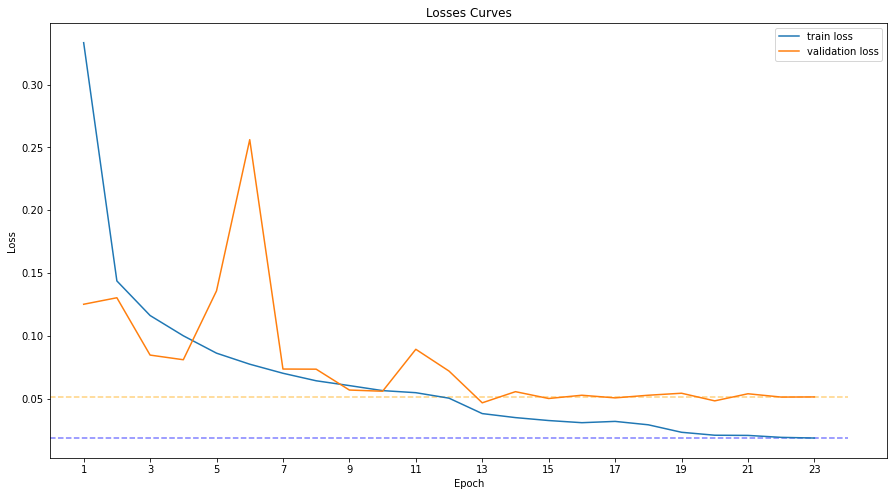

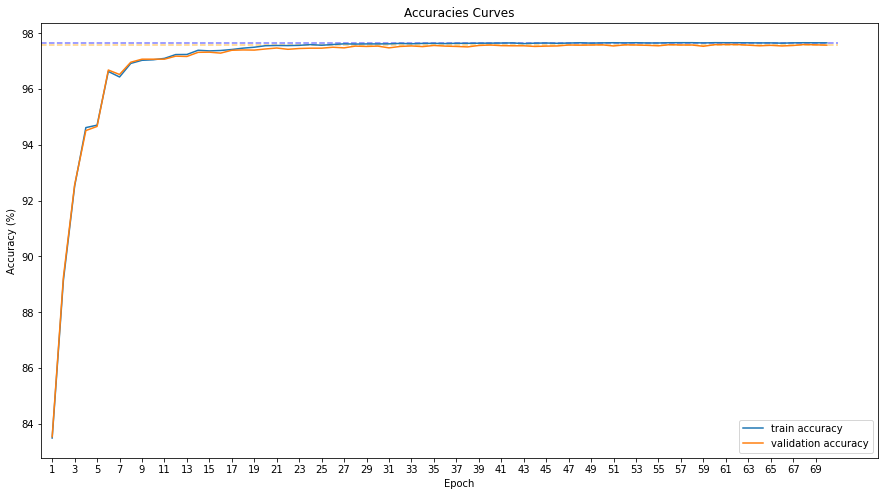

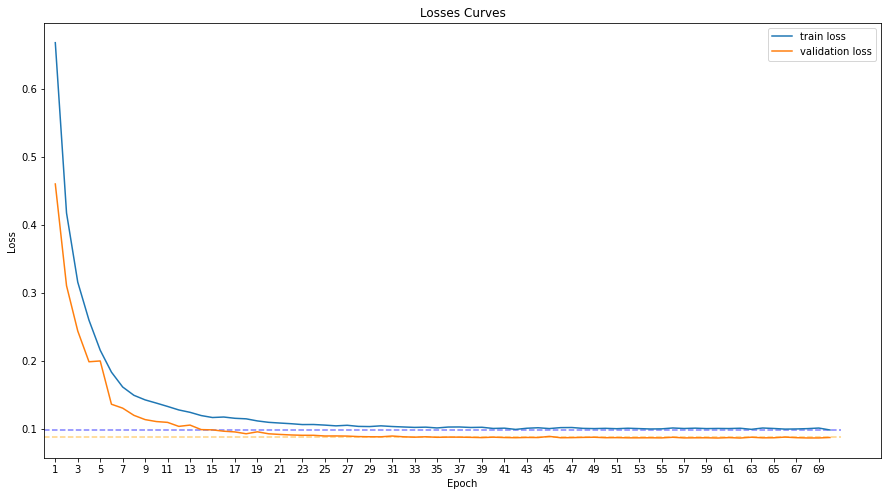

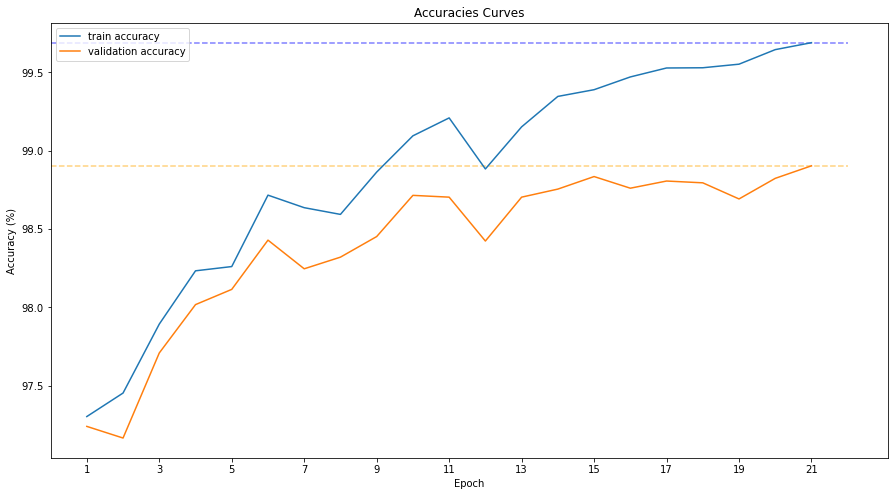

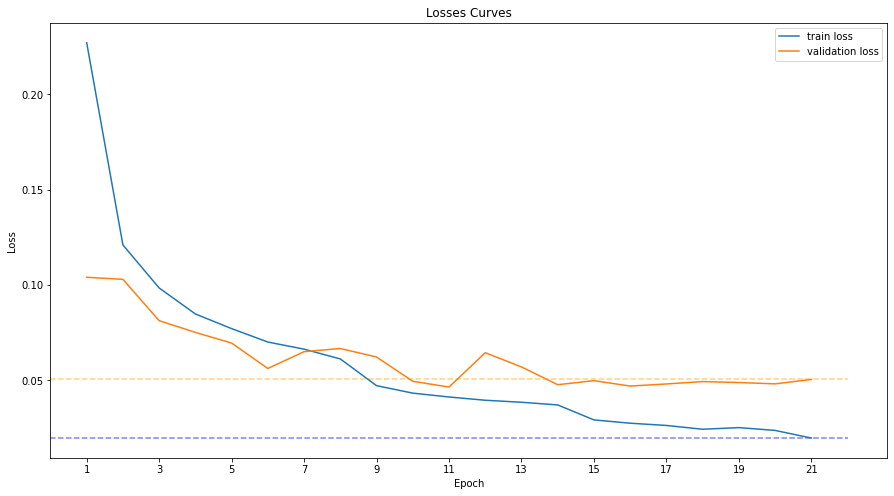

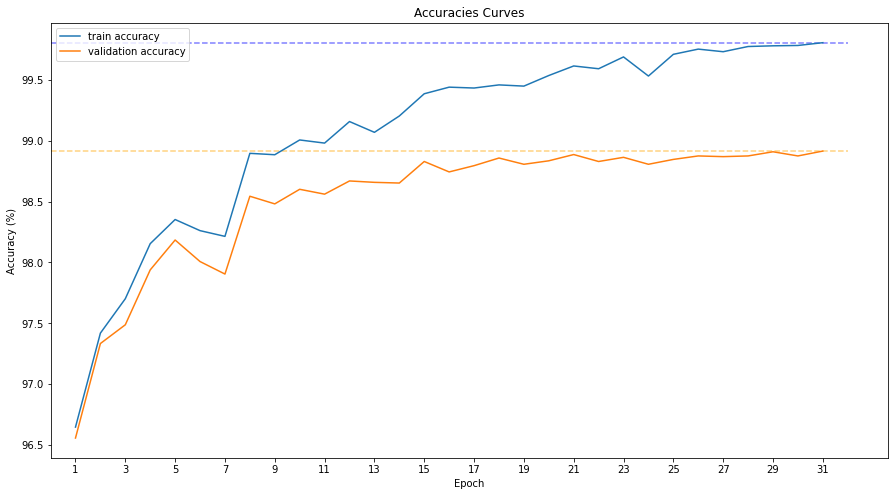

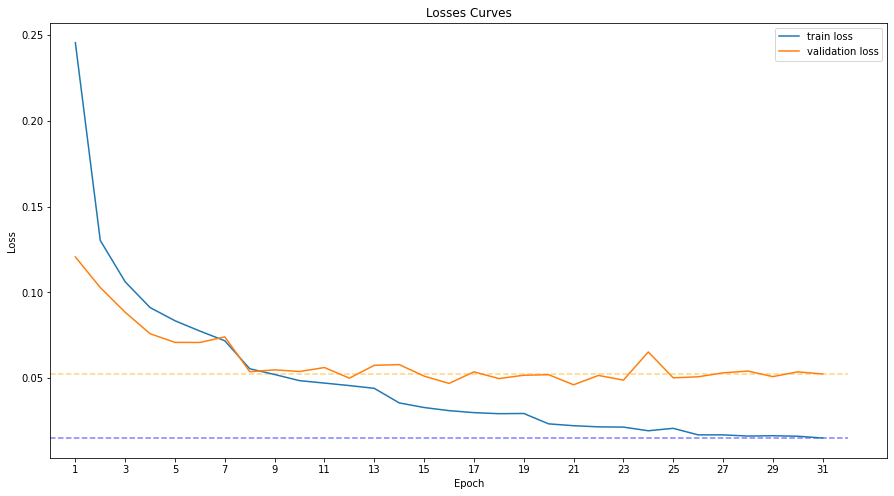

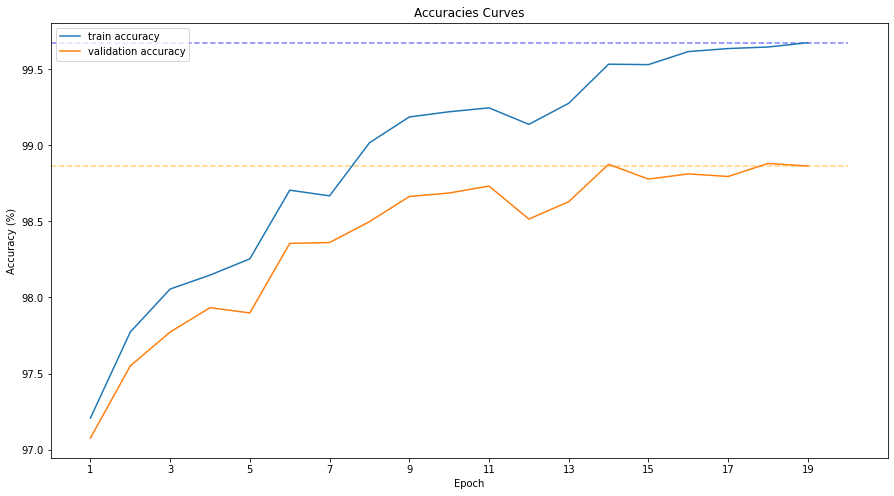

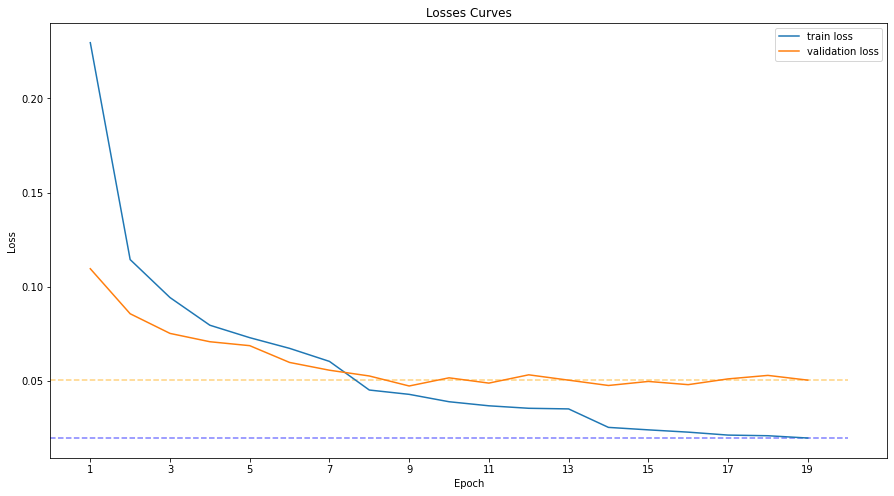

In [24]:
# Compile with Optuna
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="ECG-CNN", direction="maximize", sampler=sampler)
study.optimize(compile_model, n_trials=10)
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
 print(" {}: {}".format(key, value))

In [25]:
optuna.visualization.plot_param_importances(study)

- we preffered to take the first trial hyperparameters - smoothier learning.
- we ended with validation accuracy of 98.8%!!!!

## Trial to freeze MIT model to train the PTB model

In [ ]:
def set_parameter_requires_grad(model):
  # frozen model
  model.requires_grad_(False)
  for param in model.parameters():
    param.requires_grad = False 

In [ ]:
def train_freezed(layers):
  freezed_model = copy.deepcopy(mit_model)
  set_parameter_requires_grad(freezed_model)

  # determine the trainable layers
  if layers<1:
    return
  freezed_model.fc_layer[10] = nn.Linear(in_features=32, out_features=2, bias=True).to(device)
  if layers>1:
    freezed_model.fc_layer[7] = nn.Linear(in_features=256, out_features=32, bias=True).to(device)
    if layers > 2:
      freezed_model.fc_layer[4] = nn.Linear(in_features=1024, out_features=256, bias=True).to(device)
      if layers > 3:
        freezed_model.fc_layer[1] = nn.Linear(in_features=4608, out_features=1024, bias=True).to(device)
        if layers>4:
          return

  params_to_update = []
  for name,param in freezed_model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print(name)

  batch_size = 64
  learning_rate = 1e-4
  epochs = 200

  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)


  # Learning Rate Scheduler
  scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
                                verbose=True)

  # Early Stopping
  early_stopping = EarlyStopping(delta=0.0001, patience=10, verbose=True)

  trainloader,validloader,testloader = get_Dataloaders(ptb_train,ptb_test,batch_size)

  since = time.time()
  train(freezed_model,(trainloader,validloader),criterion,optimizer,epochs,scheduler,early_stopping)
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  test_accuracy,_,_ = calculate_measurements(freezed_model, testloader, device, criterion, nb_class)

  return test_accuracy,time_elapsed

fc_layer.10.weight
fc_layer.10.bias
Epoch: 1 | Loss: 2.0313 | Training accuracy: 37.543% | Validation accuracy: 39.433%  
Epoch: 2 | Loss: 1.4110 | Training accuracy: 69.212% | Validation accuracy: 68.213%  
Epoch: 3 | Loss: 1.2780 | Training accuracy: 71.252% | Validation accuracy: 70.318%  
EarlyStopping counter: 1 out of 10
Epoch: 4 | Loss: 1.2666 | Training accuracy: 72.176% | Validation accuracy: 70.662%  
EarlyStopping counter: 2 out of 10
Epoch: 5 | Loss: 1.2116 | Training accuracy: 72.455% | Validation accuracy: 71.134%  
EarlyStopping counter: 3 out of 10
Epoch: 6 | Loss: 1.1616 | Training accuracy: 72.562% | Validation accuracy: 71.349%  
EarlyStopping counter: 4 out of 10
Epoch: 7 | Loss: 1.0873 | Training accuracy: 72.562% | Validation accuracy: 71.435%  
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.
EarlyStopping counter: 5 out of 10
Epoch: 8 | Loss: 1.0480 | Training accuracy: 72.562% | Validation accuracy: 71.435%  
EarlyStopping counter: 6 out of 10
Epoc

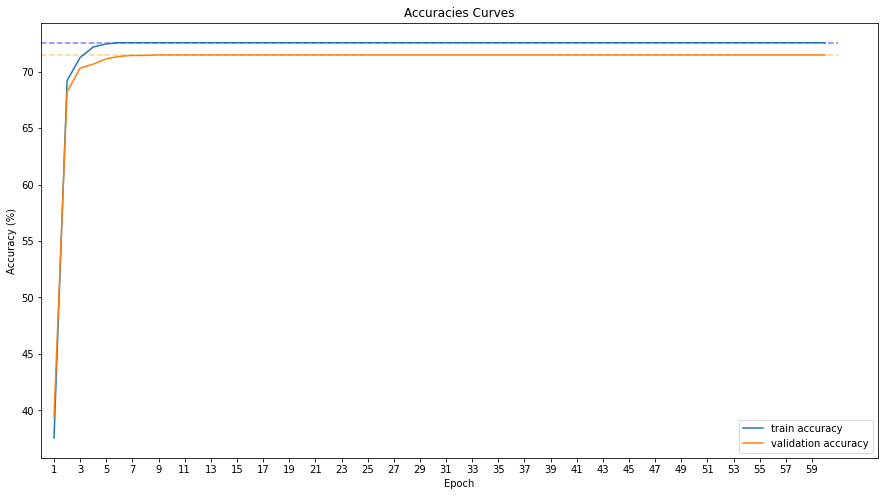

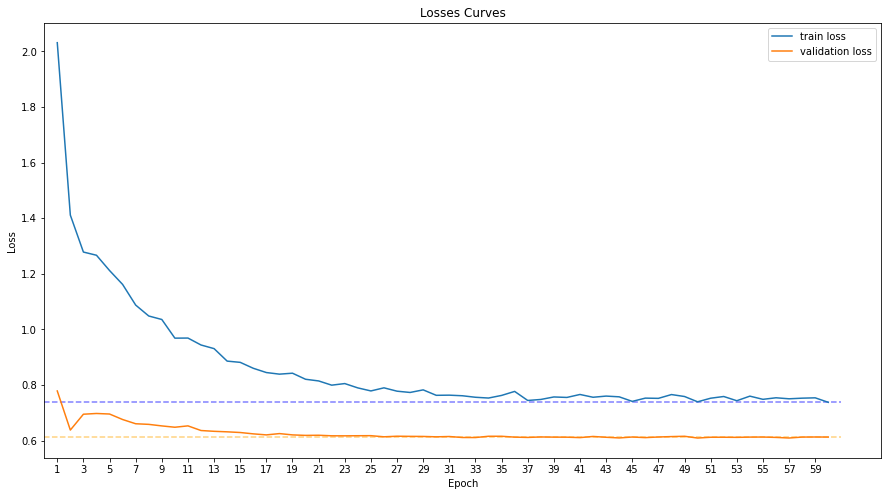

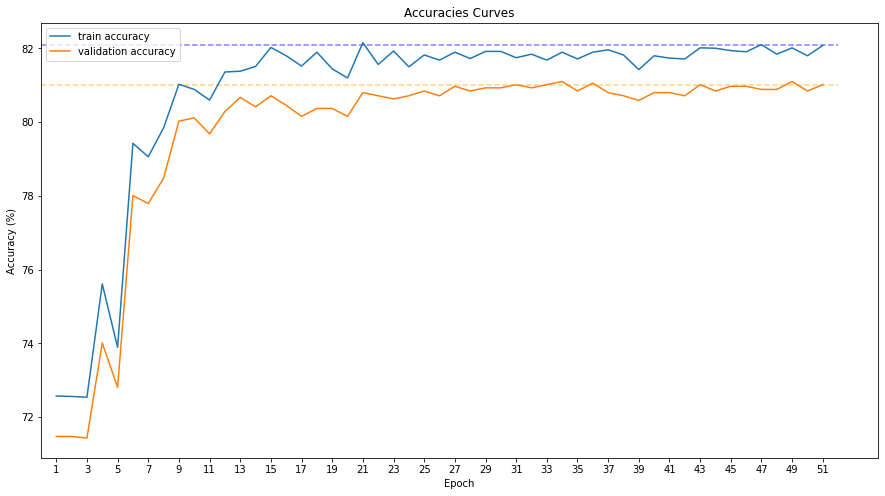

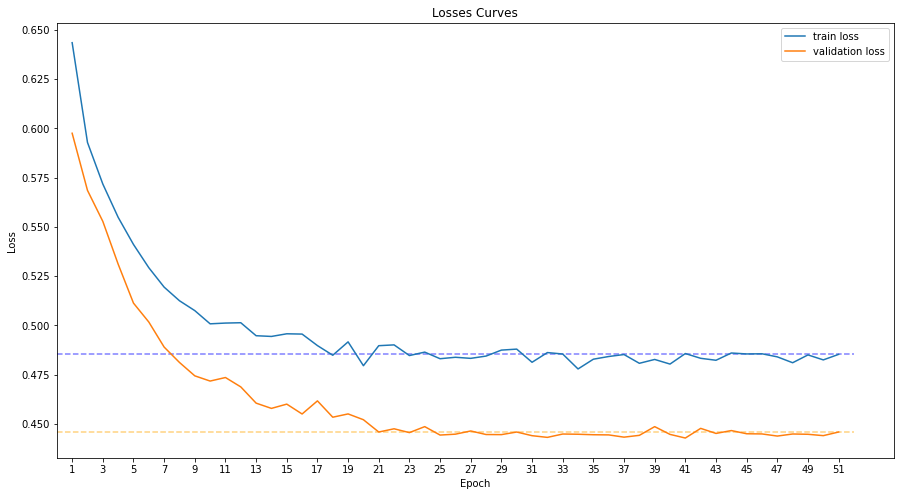

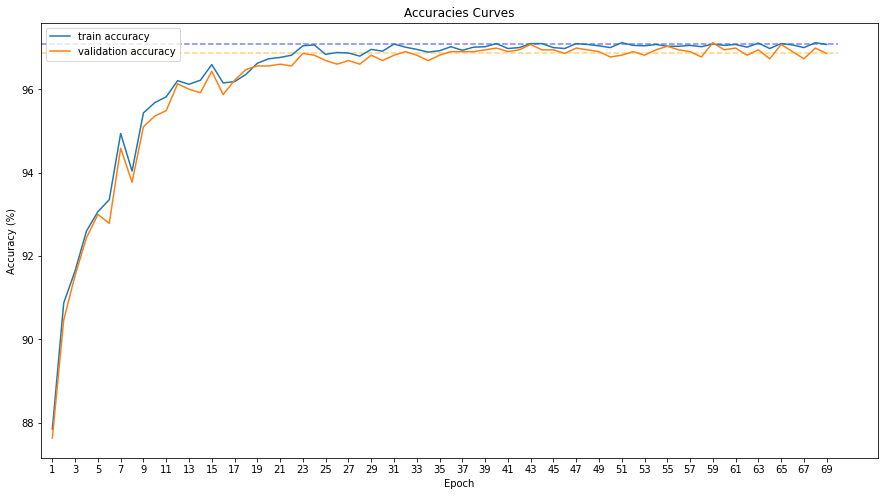

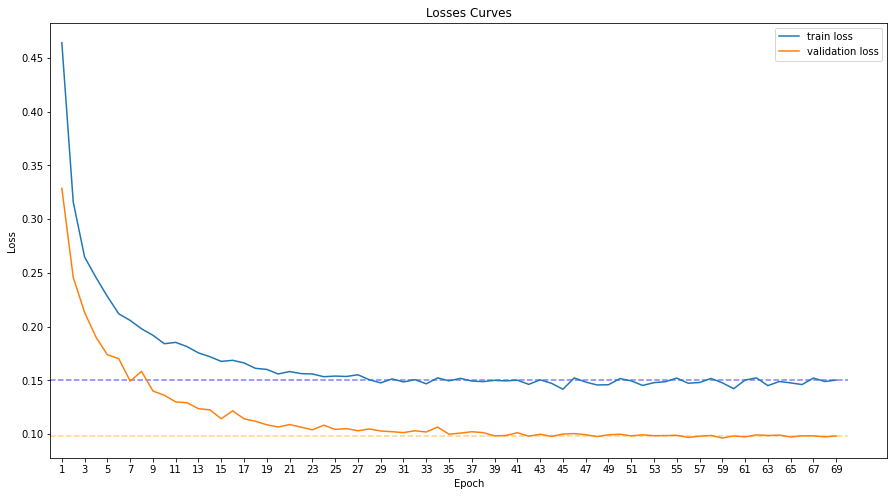

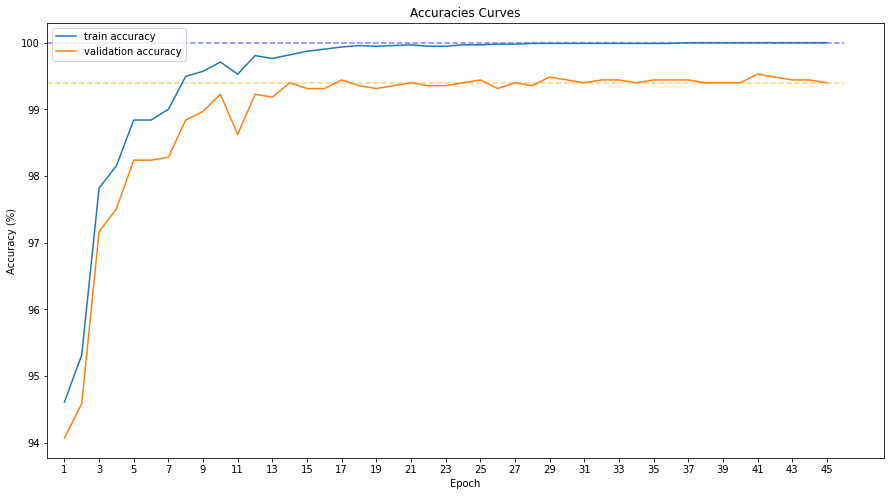

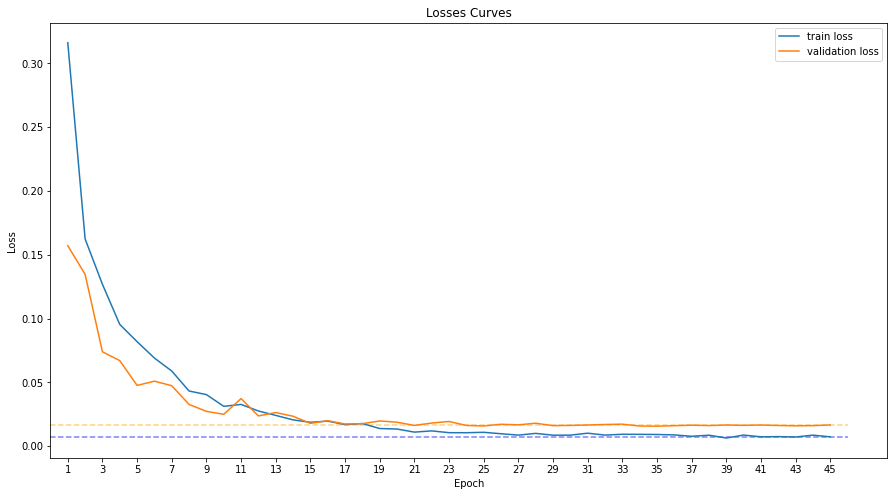

In [ ]:
accuracies = []
times = []
for layers in range(1,5):
    test_accuracy,time_elapsed = train_freezed(layers)
    accuracies.append(test_accuracy)
    times.append(time_elapsed)

accuracies.append(ptb_test_accuracy)
times.append(ptb_time_elapsed)

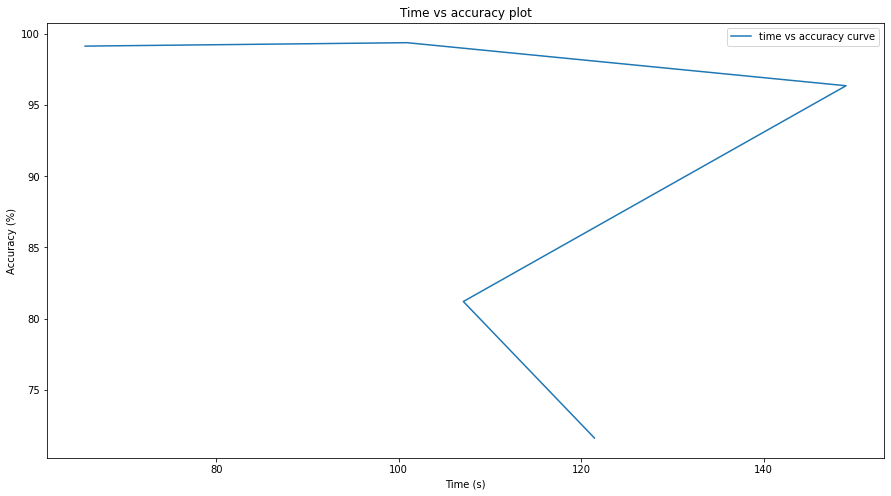

In [ ]:
# time vs accuracy plot
figure = plt.figure(figsize=(15,8))
ax = figure.add_subplot(1,1,1)
ax.plot(times,accuracies,label = "time vs accuracy curve")
ax.legend()
ax.set_title("Time vs accuracy plot")
ax.set_xlabel("Time (s)")
_=ax.set_ylabel("Accuracy (%)")

In [ ]:
accuracies

[71.61512027491409,
 81.20274914089347,
 96.3573883161512,
 99.38144329896907,
 99.14089347079039]

In [ ]:
times

[121.45202088356018,
 107.08593726158142,
 149.01860213279724,
 100.91500067710876,
 65.63965010643005]

##Analysis of steps of the cnn layers

In [ ]:
def layer_outputs(ecg, model):
    [conv_module,lin_module] = [module for module in mit_model.modules() if isinstance(module, nn.Sequential)]
    outputs = [ecg]
    names = ["normal ecg"]
    for layer in conv_module:
        ecg = layer(ecg)
        outputs.append(ecg)
        names.append(str(layer))

    ecg = ecg.view(ecg.size(0), -1)

    for layer in lin_module:
        ecg = layer(ecg)
        outputs.append(ecg)
        names.append(str(layer))

    outputs[0]=outputs[0].squeeze(0)
    output_ecg = []
    for out in outputs:
      out = out.squeeze(0).T.data.cpu().numpy()
      if len(out.shape)==2:
        output_ecg.append(out)
      else:
        output_ecg.append(out)


    fig, ax = plt.subplots(len(output_ecg), 1, figsize=(20, 100))
    for i,out in enumerate(output_ecg):
        ax[i].plot(out)
        ax[i].set_title(f'{names[i]}')
        ax[i].set_xlabel('Time (ms)')
        ax[i].set_ylabel('Amplitude (mV)')


In [ ]:
layer_outputs(torch.tensor(mit_train.loc[10:10,:186].values,dtype = torch.float32).unsqueeze(1).to(device), mit_model)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
layer_outputs(torch.tensor(mit_train.loc[72470:72470,:186].values,dtype = torch.float32).unsqueeze(1).to(device), mit_model)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
layer_outputs(torch.tensor(mit_train.loc[74693:74693,:186].values,dtype = torch.float32).unsqueeze(1).to(device), mit_model)

Output hidden; open in https://colab.research.google.com to view.